Simple Segmentation Net

In [1]:
# overview
Scans = {
    0: 'FLAIR',
    1: 'T1w',
    2: 't1gd',
    3: 'T2w'}

Labels = {
    0: 'background',
    1: 'edema',
    2: 'non-enhancing tumor',
    3: 'enhancing tumour'}

In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os

import SimpleITK as sitk

from Dataset_Utils import BraTS_TrainingDataset
from Dataset_Utils import plot_batch, crop_batch, decrop_batch, split_cube

torch.manual_seed(42)

Data Loading

In [3]:
# PATH
dataset_path = '/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/cropped/'

train_data = BraTS_TrainingDataset(dataset_path)

trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=1, shuffle=True, num_workers=0)

train_iter = iter(trainloader)

sample_batch = train_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)

# plot_batch(sample_batch, num_rows=2, height=75)

/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/cropped/imagesTr
/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/cropped/labelsTr
torch.Size([1, 4, 155, 192, 192])
torch.Size([1, 155, 192, 192])


Create the model

In [4]:
# don't run this cell, it needs too much memory

# class BTSegNet(nn.Module):
#         
#     def downward_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
#         """
#         The downward blocks are part of the contracting path.
#         Utility:
#         - decrease the depth, height and width.
#         - increase the number of channels.
#         The result is that features get more high level
#         and spatial information decreases with each downward block.
#         """
#         downward_block = nn.Sequential(
#             nn.Conv3d(in_channels=in_channels, out_channels=out_channels,
#                       kernel_size=kernel_size, stride=stride, padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm3d(out_channels),
#                 
#             nn.Conv3d(in_channels=out_channels, out_channels=out_channels,
#                       kernel_size=kernel_size, stride=stride, padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm3d(out_channels),
#             )
#         return downward_block
#     
#     def upward_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
#         """
#         The upward blocks are part of the expanding path.
#         Utility:
#         - increase the number of depth, height and width.
#         - decrease the number of channels.
#         The result is a segmentation map that increases
#         in resolution for each upward block.
#         """
#         mid_channels = in_channels//2
#         # E.g.: in_c = 512, mid_c = 256, out_c = 128
#         
#         upward_block = nn.Sequential(
#             nn.Conv3d(in_channels=in_channels, out_channels=mid_channels,
#                       kernel_size=kernel_size, stride=stride, padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm3d(mid_channels),
#                 
#             nn.Conv3d(in_channels=mid_channels, out_channels=out_channels,
#                       kernel_size=kernel_size, stride=stride, padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm3d(out_channels))
#         
#         return upward_block
#     
#     def __init__(self, num_modalities, num_classes, img_height, img_width):
#         
#         self.DEBUG = False
#         
#         super(BTSegNet, self).__init__()
#         self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2)
#         
#         # downward layers
#         self.down1 = self.downward_block(in_channels=num_modalities, out_channels=32, 
#                                       kernel_size=3, stride=1, padding=1)
#     
#         self.down2 = self.downward_block(in_channels=32, out_channels=32, 
#                                       kernel_size=3, stride=1, padding=1)
#         
#         self.down3 = self.downward_block(in_channels=32, out_channels=64, 
#                                       kernel_size=3, stride=1, padding=1)
#         
#         self.same_conv = nn.Sequential(
#             nn.Conv3d(in_channels=64, out_channels=64,
#                       kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm3d(64),
#         )
#         
#         self.upconv1 = nn.ConvTranspose3d(in_channels=64, out_channels=64,
#                               kernel_size=3, stride=2, padding=1, output_padding=1)
#         
#         self.up1 = self.upward_block(in_channels=128, out_channels=64, 
#                                      kernel_size=3, stride=1, padding=0)
#         
#         self.upconv2 = nn.ConvTranspose3d(in_channels=64, out_channels=32,
#                               kernel_size=10, stride=2, padding=0, output_padding=0)
#         
#         self.up2 = self.upward_block(in_channels=64, out_channels=32, 
#                                      kernel_size=3, stride=1, padding=0)
#         
#         self.upconv3 = nn.ConvTranspose3d(in_channels=32, out_channels=16,
#                               kernel_size=9, stride=2, padding=0, output_padding=1)
#         
#         self.up3 = self.upward_block(in_channels=48, out_channels=8, 
#                                      kernel_size=3, stride=1, padding=1)
#         
#         self.out_conv = nn.Sequential(
#             nn.Conv3d(in_channels=8, out_channels=4,
#                       kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#         )
#         
#     def forward(self, x):
#         x = torch.FloatTensor(x)
#         
#         # downward layers
#         x = self.down1(x)
#         l1_out = torch.clone(x)
#         x = self.maxpool(x)
#         
#         x = self.down2(x)
#         l2_out = torch.clone(x)
#         x = self.maxpool(x)
#         
#         x = self.down3(x)
#         l3_out = torch.clone(x)
#         x = self.maxpool(x)
#         
#         # bottom floor
#         x = self.same_conv(x)
#         x = self.same_conv(x)
#         
#         if self.DEBUG:
#             print('l1_out:', l1_out.shape)
#             print('l2_out:', l2_out.shape)
#             print('l3_out:', l3_out.shape)
#             print('x:', x.shape)
#         
#         # upward layers
#         x = self.upconv1(x)
#         if self.DEBUG:
#             print('after upconv1:', x.shape)
#         x = torch.cat((l3_out, x), dim=1) # x:[1, 64, 20, 24, 24] and l3:[1, 64, 20, 24, 24]
#         if self.DEBUG:
#             print('after cat:', x.shape)
#         x = self.up1(x)
#         if self.DEBUG:
#             print('after up1:', x.shape)
#         
#         x = self.upconv2(x)
#         if self.DEBUG:
#             print('after upconv2:', x.shape)
#         x = torch.cat((l2_out, x), dim=1) # x:[1, 32, 40, 48, 48] and l2: [1, 32, 40, 48, 48]
#         if self.DEBUG:
#             print('after cat:', x.shape)
#         x = self.up2(x)
#         if self.DEBUG:
#             print('after up2:', x.shape)
#         
#         x = self.upconv3(x)
#         if self.DEBUG:
#             print('after upconv3:', x.shape)
#         x = torch.cat((l1_out, x), dim=1) # x:[1, 32, 80, 96, 96] and l1: [1, 32, 80, 96, 96]
#         if self.DEBUG:
#             print('after cat:', x.shape)
#         x = self.up3(x)
#         if self.DEBUG:
#             print('after up3:', x.shape)
#         
#         # output conv block
#         x = self.out_conv(x)
#         if self.DEBUG:
#             print('after out conv:', x.shape)       
#         return x
#     
# # summary
# # print(BTSegNet(num_modalities=4, num_classes=4, img_height=96, img_width=96))
# 
# # init model
# model = BTSegNet(num_modalities=4, num_classes=4, img_height=96, img_width=96)

In [5]:
class SmallBTSegNet(nn.Module):
        
    def downward_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        """
        The downward blocks are part of the contracting path.
        Utility:
        - decrease the depth, height and width.
        - increase the number of channels.
        The result is that features get more high level
        and spatial information decreases with each downward block.
        """
        downward_block = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm3d(out_channels),
                
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm3d(out_channels),
            )
        return downward_block
    
    def upward_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        """
        The upward blocks are part of the expanding path.
        Utility:
        - increase the number of depth, height and width.
        - decrease the number of channels.
        The result is a segmentation map that increases
        in resolution for each upward block.
        """
        mid_channels = in_channels//2
        # E.g.: in_c = 512, mid_c = 256, out_c = 128
        
        upward_block = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=mid_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm3d(mid_channels),
                
            nn.Conv3d(in_channels=mid_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm3d(out_channels))
        
        return upward_block
    
    def __init__(self, num_modalities, num_classes, img_height, img_width):
        
        self.DEBUG = False
        
        super(SmallBTSegNet, self).__init__()
        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # downward layers
        self.down1 = self.downward_block(in_channels=num_modalities, out_channels=8, 
                                      kernel_size=3, stride=1, padding=1)
    
        self.down2 = self.downward_block(in_channels=8, out_channels=8, 
                                      kernel_size=3, stride=1, padding=1)
        
        self.down3 = self.downward_block(in_channels=8, out_channels=16, 
                                      kernel_size=3, stride=1, padding=1)
        
        self.same_conv = nn.Sequential(
            nn.Conv3d(in_channels=16, out_channels=16,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(16),
        )
        
        self.upconv1 = nn.ConvTranspose3d(in_channels=16, out_channels=16,
                              kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.up1 = self.upward_block(in_channels=32, out_channels=16, 
                                     kernel_size=3, stride=1, padding=0)
        
        self.upconv2 = nn.ConvTranspose3d(in_channels=16, out_channels=8,
                              kernel_size=10, stride=2, padding=0, output_padding=0)
        
        self.up2 = self.upward_block(in_channels=16, out_channels=8, 
                                     kernel_size=3, stride=1, padding=0)
        
        self.upconv3 = nn.ConvTranspose3d(in_channels=8, out_channels=4,
                              kernel_size=9, stride=2, padding=0, output_padding=1)
        
        self.up3 = self.upward_block(in_channels=12, out_channels=4, 
                                     kernel_size=3, stride=1, padding=1)
        
        self.out_conv = nn.Sequential(
            nn.Conv3d(in_channels=4, out_channels=4,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = torch.FloatTensor(x)
        
        # downward layers
        x = self.down1(x)
        l1_out = torch.clone(x)
        x = self.maxpool(x)
        
        x = self.down2(x)
        l2_out = torch.clone(x)
        x = self.maxpool(x)
        
        x = self.down3(x)
        l3_out = torch.clone(x)
        x = self.maxpool(x)
        
        # bottom floor
        x = self.same_conv(x)
        x = self.same_conv(x)
        
        if self.DEBUG:
            print('l1_out:', l1_out.shape)
            print('l2_out:', l2_out.shape)
            print('l3_out:', l3_out.shape)
            print('x:', x.shape)
        
        # upward layers
        x = self.upconv1(x)
        if self.DEBUG:
            print('after upconv1:', x.shape)
        x = torch.cat((l3_out, x), dim=1)
        if self.DEBUG:
            print('after cat:', x.shape)
        x = self.up1(x)
        if self.DEBUG:
            print('after up1:', x.shape)
        
        x = self.upconv2(x)
        if self.DEBUG:
            print('after upconv2:', x.shape)
        x = torch.cat((l2_out, x), dim=1)
        if self.DEBUG:
            print('after cat:', x.shape)
        x = self.up2(x)
        if self.DEBUG:
            print('after up2:', x.shape)
        
        x = self.upconv3(x)
        if self.DEBUG:
            print('after upconv3:', x.shape)
        x = torch.cat((l1_out, x), dim=1)
        if self.DEBUG:
            print('after cat:', x.shape)
        x = self.up3(x)
        if self.DEBUG:
            print('after up3:', x.shape)
        
        # output conv block
        x = self.out_conv(x)
        if self.DEBUG:
            print('after out conv:', x.shape)       
        return x
    
# summary
# print(SmallBTSegNet(num_modalities=4, num_classes=4, img_height=96, img_width=96))

# init model
model = SmallBTSegNet(num_modalities=4, num_classes=4, img_height=96, img_width=96)

In [6]:
# Sample a minicube batch
minicube_batch = split_cube(train_iter.next())

In [7]:
voxel_logits_batch = model.forward(minicube_batch['image'][:1,:,:,:,:])

In [8]:
criterion = nn.CrossEntropyLoss()

Training loop: Overfit to one sample

In [9]:
def split_minicube_batch(minicube_batch, epoch):
    if epoch%4 == 0:
        voxel_logits_batch = model.forward(minicube_batch['image'][:2,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][:2,:,:,:].long())
        return loss
    
    elif epoch%4 == 1:
        voxel_logits_batch = model.forward(minicube_batch['image'][2:4,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][2:4,:,:,:].long())
        return loss
    
    elif epoch%4 == 2:
        voxel_logits_batch = model.forward(minicube_batch['image'][4:6,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][4:6,:,:,:].long())
        return loss
    
    else:
        voxel_logits_batch = model.forward(minicube_batch['image'][6:,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][6:,:,:,:].long())
        return loss

In [10]:
# define optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.05)

# training loop
epochs = 20
losses = []
for epoch in range(epochs):
    
    if epoch%8 == 0:
        # Get a new minicube batch
        minicube_batch = split_cube(train_iter.next())
    
    loss = split_minicube_batch(minicube_batch, epoch)
    losses.append(loss)
    
    print(f'epoch {epoch:3d}: loss={loss:3.3f}')
    
    # backprop loss
    optim.zero_grad()
    loss.backward()
    optim.step()

epoch   0: loss=1.407
epoch   1: loss=1.776
epoch   2: loss=1.217
epoch   3: loss=0.786
epoch   4: loss=0.569
epoch   5: loss=0.513
epoch   6: loss=0.475
epoch   7: loss=0.380
epoch   8: loss=0.330
epoch   9: loss=0.365
epoch  10: loss=0.259
epoch  11: loss=0.297
epoch  12: loss=0.273
epoch  13: loss=0.253
epoch  14: loss=0.213
epoch  15: loss=0.206
epoch  16: loss=0.214
epoch  17: loss=0.116
epoch  18: loss=0.565
epoch  19: loss=0.119


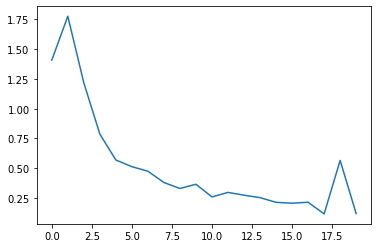

In [11]:
losses_array = [l.detach().numpy() for l in losses]
plt.plot(losses_array)

Predict

In [12]:
voxel_logits_batch = model.forward(minicube_batch['image'][None,5,:,:,:,:])

In [13]:
sm = nn.Softmax(dim=1)
voxel_probs_batch = sm(voxel_logits_batch)
voxel_probs_batch.shape

torch.Size([1, 4, 80, 96, 96])

In [14]:
probs, out = torch.max(voxel_probs_batch, dim=1)
out.shape

torch.Size([1, 80, 96, 96])

prediction:


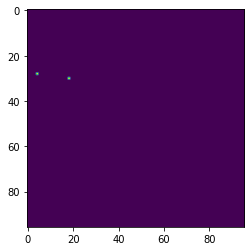

In [15]:
print('prediction:')
plt.imshow(out[0, 30, :, :])

label:


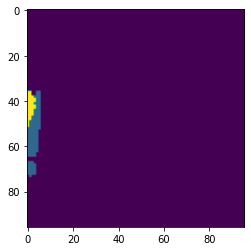

In [16]:
print('label:')
plt.imshow(minicube_batch['label'][5, 30, :, :])